## 1.

*Recogiendo los datos de coronavirus de la página https://ourworldindata.org/coronavirus-source-data* 

A partir de la letra de tu DNI, elige al país que empieza por dicha letra que más fallecidos tenga. Si el país elegido no está entre el top 20 de fallecidos, elige como país España.

En este caso, utilizaremos las columnas:

- Nuevos casos
- Nuevos fallecidos
- Población
- Fallecidos totales
- Casos totales

La fecha debe estar en el índice.

1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

2. Elimina la columna "Población".

3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y n_repeats = 7 para este ejercicio y solo para la columna "nuevos casos".

In [98]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")

In [92]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [93]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [94]:
#Estos son los 20 paises con más muertes del mundo.
df_20 = df.groupby("location").sum().sort_values(by="total_deaths", ascending=False)[5:].head(20)
df_20

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
location,,,,,,,,,,,,,,,,,,,,,
United States,6.749717e+09,33537994.0,3.349965e+07,136169244.0,601741.0,600700.854,2.039173e+07,101322.437,101206.604,411384.155,...,618.0,77810.835,5556.85,9836.5,12669.0,0.000,1426.55,40612.90,476.890,1385.73
Asia,7.690932e+09,53508165.0,5.310495e+07,119779487.0,763284.0,754279.133,1.657583e+06,11532.306,11445.400,25815.385,...,0.0,0.000,0.00,0.0,0.0,0.000,0.00,0.00,0.000,0.00
Brazil,3.013966e+09,17883750.0,1.763072e+07,82706944.0,500800.0,493617.292,1.417941e+07,84135.297,82944.896,389100.363,...,1632.0,85421.280,3892.80,4848.0,8592.0,0.000,1056.00,36422.40,367.200,526.10
India,3.838139e+09,29881772.0,2.969754e+07,51972141.0,386708.0,381163.866,2.781252e+06,21653.388,21519.897,37660.846,...,10748.4,143115.960,5267.73,963.3,10444.2,30191.850,268.71,35317.62,327.015,0.00
Mexico,5.117721e+08,2471741.0,2.463375e+06,47814921.0,230959.0,230585.584,3.969295e+06,19170.780,19105.880,370851.621,...,1340.0,81891.688,7000.16,3698.4,11470.4,47085.992,739.68,40226.80,417.544,3831.02
Peru,4.029184e+08,2023179.0,2.012607e+06,39285402.0,189933.0,189364.716,1.222007e+07,61360.805,61040.164,1191483.234,...,1858.5,45535.905,3159.45,2548.8,0.0,0.000,849.60,40748.94,412.587,10287.70
United Kingdom,8.788656e+08,4636991.0,4.607784e+06,31619513.0,128234.0,128196.135,1.294620e+07,68305.555,67875.331,465773.675,...,101.2,61801.322,2165.68,10120.0,12498.2,0.000,1285.24,41147.92,471.592,905.73
Italy,7.256608e+08,4252095.0,4.248408e+06,28662083.0,127253.0,127137.430,1.200197e+07,70326.933,70265.961,474052.544,...,1012.0,57254.406,2418.68,10018.8,14066.8,0.000,1609.08,42256.06,451.352,955.12
Africa,9.960575e+08,5178520.0,5.105831e+06,25525206.0,137081.0,135856.570,7.429949e+05,3862.858,3808.606,19040.162,...,0.0,0.000,0.00,0.0,0.0,0.000,0.00,0.00,0.000,0.00


In [95]:
#El primero es el país que me toca según la propuesta del ejercicio. Si se encuentra dentro de df_20, utilizaré sus valores. Sino, cogeré los de España.
search ="M"
bool_series = df["location"].str.startswith(search, na = False)
df2 = df[bool_series]

df2 = df2.groupby("location").sum().sort_values(by="total_deaths", ascending=False)

df2.head(1)

#Ha salido México, 6ta posición mundial, es una referencia válida para el ejercicio.

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
location,,,,,,,,,,,,,,,,,,,,,
Mexico,511772094.0,2471741.0,2463374.717,47814921.0,230959.0,230585.584,3969294.71,19170.78,19105.88,370851.621,...,1340.0,81891.688,7000.16,3698.4,11470.4,47085.992,739.68,40226.8,417.544,3831.02


In [97]:
#Preparo la tabla como me dice el enunciado: índice, columnas, location:país.
data = df[["location","new_cases","new_deaths","population","total_deaths", "total_cases"]]
data.set_index(df["date"], inplace=True)
data = data[data["location"] == "Mexico"]
data = data.drop(columns="location")
print(data.shape)
data.head(20)

(536, 5)


,new_cases,new_deaths,population,total_deaths,total_cases
date,,,,,
2020-01-01,NaN,NaN,128932753.0,NaN,NaN
2020-01-02,NaN,NaN,128932753.0,NaN,NaN
2020-01-03,NaN,NaN,128932753.0,NaN,NaN
2020-01-04,NaN,NaN,128932753.0,NaN,NaN
2020-01-05,NaN,NaN,128932753.0,NaN,NaN
2020-01-06,NaN,NaN,128932753.0,NaN,NaN
2020-01-07,NaN,NaN,128932753.0,NaN,NaN
2020-01-08,NaN,NaN,128932753.0,NaN,NaN
2020-01-09,NaN,NaN,128932753.0,NaN,NaN


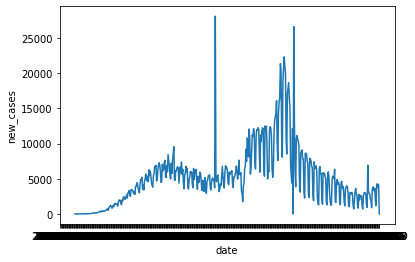

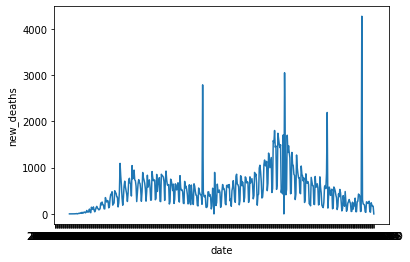

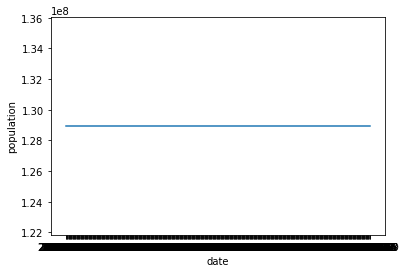

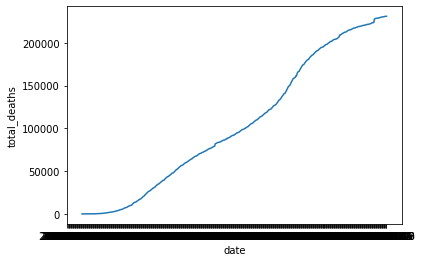

In [107]:
#Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.
for i in range(4):
    sns.lineplot(x=data.index, y=data.iloc[:,i], size_order=5)
    plt.show()

In [131]:
no_ticks = range(0,len(data),50)

sns.lineplot(x=data.index, y=data["total_deaths"], size_order=5)
plt.xticks(ticks=no_ticks, rotation=65)
plt.show()


AttributeError: module 'matplotlib.pyplot' has no attribute 'fig'